/tmp/ipykernel_17320/2148119489.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  c = sigo / (v * beta_c[t] * (1 + 2 * alpha_c[t]) * np.sqrt(1 / zth**2 - 2 * sigi**2))
/tmp/ipykernel_17320/2148119489.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  c_tr = sigo / (v * beta_c[t] * (1 + 2 * 0.5 * alpha_c[t]) * np.sqrt(1 / zth**2 - 2 * sigi**2))
/tmp/ipykernel_17320/2148119489.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  beta_c[t + 1] = beta_c[t] + dt / tau * (k_z_th / (v * beta_c[t]))


ValueError: x and y must have same first dimension, but have shapes (1799,) and (1,)

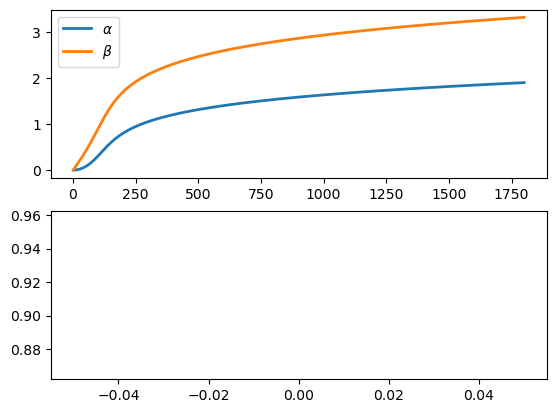

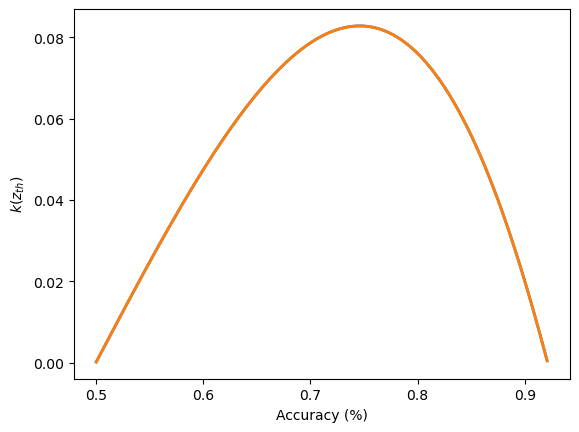

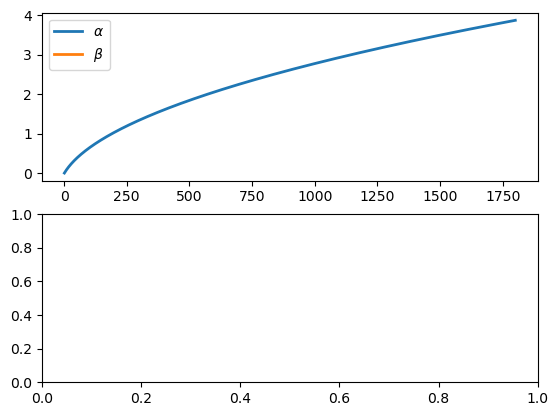

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf

# Parameter values
delta_input = 10
sigma_L1 = 16
sigi = 0.5
sigo = 5
tau = 5
dt = 1
Nitr = 1800
N1 = 101

# Create angle array
ang = np.linspace(-90, 90, N1)

# Gaussian profiles
gp = norm.pdf(ang, delta_input/2, sigma_L1)
gm = norm.pdf(ang, -delta_input/2, sigma_L1)
gp = gp / np.max(gp)
gm = gm / np.max(gm)

d = gp - gm

v = np.dot(d, gp)

# Constant difficulty
c = 1
alpha = np.zeros(Nitr)
beta = np.zeros(Nitr)

for t in range(Nitr - 1):
    gamma = c * v * beta[t] * (1 + 2 * alpha[t])
    z = gamma / (np.sqrt(2 * sigi**2 * gamma**2 + sigo**2))
    acc = 1/2 * (1 - erf(-z / np.sqrt(2)))
    f = (sigo**2 * np.exp(-z**2 / 2)) / (2 * sigi**2 * gamma**2 + sigo**2)**(3/2)

    alpha[t + 1] = alpha[t] + dt / tau * (c * f / (2 * np.sqrt(2 * np.pi)) * beta[t])
    beta[t + 1] = beta[t] + dt / tau * (c * f / (2 * np.sqrt(2 * np.pi)) * (1 + 2 * alpha[t]))

# Plot results
plt.subplot(211)
plt.plot(range(1, Nitr + 1), alpha, range(1, Nitr + 1), beta, linewidth=2)
plt.legend(['$\\alpha$', '$\\beta$'])
plt.subplot(212)
plt.plot(acc, linewidth=2)

# Plot k_z_th as a function of zth
zth_max = np.sqrt(1 / (2 * sigi**2))
zth = np.arange(0.001, zth_max, 0.01)
acc = 1/2 * (1 - erf(-zth / np.sqrt(2)))
k_z_th = (1 / (2 * np.sqrt(2 * np.pi))) * sigo**3 * np.exp(-zth**2 / 2) / np.sqrt(1 / zth**2 - 2 * sigi**2) / (
            (2 * sigi**2 * sigo**2 * zth**2) / (1 - 2 * sigi**2 * zth**2) + sigo**2)**(3/2)
k_z_th2 = (1 / (2 * np.sqrt(2 * np.pi))) * zth * (1 - 2 * sigi**2 * zth**2) * np.exp(-zth**2 / 2)

plt.figure()
plt.plot(acc, k_z_th, acc, k_z_th2, linewidth=2)
plt.xlabel('Accuracy (%)')
plt.ylabel('$k(z_{th})$')

# Contrast shaping
zth = 0.5
k_z_th = (1 / (2 * np.sqrt(2 * np.pi))) * sigo**3 * np.exp(-zth**2 / 2) / np.sqrt(1 / zth**2 - 2 * sigi**2) / (
            (2 * sigi**2 * sigo**2 * zth**2) / (1 - 2 * sigi**2 * zth**2) + sigo**2)**(3/2)
alpha_c = np.zeros(Nitr)
beta_c = np.zeros(Nitr)

for t in range(Nitr - 1):
    acc = 1/2 * (1 - erf(-zth) / np.sqrt(2))
    c = sigo / (v * beta_c[t] * (1 + 2 * alpha_c[t]) * np.sqrt(1 / zth**2 - 2 * sigi**2))
    c_tr = sigo / (v * beta_c[t] * (1 + 2 * 0.5 * alpha_c[t]) * np.sqrt(1 / zth**2 - 2 * sigi**2))
    alpha_c[t + 1] = alpha_c[t] + dt / tau * (k_z_th / (v * (1 + 2 * alpha_c[t])))
    beta_c[t + 1] = beta_c[t] + dt / tau * (k_z_th / (v * beta_c[t]))

# Plot results
plt.figure()
plt.subplot(211)
plt.plot(range(1, Nitr + 1), alpha_c, range(1, Nitr + 1), beta_c, linewidth=2)
plt.legend(['$\\alpha$', '$\\beta$'])
plt.subplot(212)
plt.plot(range(1, Nitr), c, linewidth=2)
plt.ylim([0, 1])

# Orientation difference shaping
kv = 15.765
zth = 0.8
kv_zth = c / (2 * np.sqrt(2 * np.pi)) * (1 - 2 * sigi**2 * zth**2)**(3/2) * np.exp(-zth**2 / 2) / sigo
alpha_v = np.zeros(Nitr)
beta_v = np.zeros(Nitr)
dth = np.zeros(Nitr - 1)

for t in range(Nitr - 1):
    acc = 1/2 * (1 - erf(-zth) / np.sqrt(2))
    dth[t] = np.sqrt(-4 * sigma_L1**2 * np.log(1 - sigo / (kv * c * beta_v[t] * (1 + 2 * alpha_v[t]) * np.sqrt(1 / zth**2 - 2 * sigi**2))))
    if np.real(dth[t]) < 10 and np.imag(dth[t]) == 0:
        adj = dth[t] / 10
    else:
        adj = 1
    alpha_v[t + 1] = alpha_v[t] + dt / tau * (kv_zth * adj * beta_v[t])
    beta_v[t + 1] = beta_v[t] + dt / tau * (kv_zth * (1 + 2 * adj * alpha_v[t]))

# Plot results
plt.figure()
plt.subplot(211)
plt.plot(range(1, Nitr + 1), alpha_v, range(1, Nitr + 1), beta_v, linewidth=2)
plt.legend(['$\\alpha$', '$\\beta$'])
plt.subplot(212)
plt.plot(np.real(dth), linewidth=2)
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

# Parameter values
delta_input = 1
sigma_L1 = 16
targ = 1
tau = 1
dt = 0.005
Nitr = 800
N1 = 101

# Create angle array
ang = np.linspace(-90, 90, N1)

# Gaussian profiles
gp = norm.pdf(ang, delta_input/2, sigma_L1)
gm = norm.pdf(ang, -delta_input/2, sigma_L1)
gp = gp / np.max(gp)
gm = gm / np.max(gm)

d = gp - gm

v = np.dot(d, gp)

# Neuron parameters
x = np.eye(2)
y = np.array([1, -1])
sig_i = 1
sig_e = 1
alpha = 1
beta = 1
W1 = np.vstack([gp, gm]) + alpha * np.vstack([d, -d])
W2 = beta * np.reshape(d, (2, 1))
W = np.dot(W2, W1)

mu = np.dot(W, x)
Sig = np.dot(np.dot(W, x), np.dot(x.T, W))

sv = y
mu_out = 1/2 * np.dot(sv, W.T)
gamma = v * beta * (1 + 2 * alpha)

z = gamma / np.sqrt(2 * sig_i**2 * gamma**2 + sig_e**2)
acc = 1/2 * (1 - np.math.erf(-z / np.sqrt(2)))

# Numerically double check
P = 1000000
xi = np.tile(x, (1, P))
xi = xi + sig_i * np.random.randn(*xi.shape)
yi = np.tile(y, (1, P))
yhi = np.dot(W, xi) + sig_e * np.random.randn(*yi.shape)

acc_emp = np.mean((yi * yhi) > 0)
acc_analy = acc

z_emp = np.mean(yi * yhi) / np.std(yi * yhi, axis=1)
z_analy = z

# Plotting
dThetas = np.round(np.linspace(0, 180, 100))
v_num = np.zeros(len(dThetas))

for tmp, dTheta in enumerate(dThetas):
    v_num[tmp], _ = quad(lambda x: 1/np.sqrt(2 * np.pi * sigma_L1**2) * np.exp(-x**2 / (2 * sigma_L1**2)) * (
            np.exp(-x**2 / (2 * sigma_L1**2)) - np.exp(-(x - dTheta)**2 / (2 * sigma_L1**2))), -np.inf, np.inf)

sigma = sigma_L1
v_analy = 1/2 * np.sqrt(np.pi * sigma**2) * (1 - np.exp(-dThetas**2 / (4 * sigma**2)))

plt.plot(dThetas, v_num, label='num')
plt.plot(dThetas, 2 * v_analy / np.sqrt(2 * np.pi * sigma**2), label='analy')
plt.legend()

# Try it...
alpha_t = np.zeros(Nitr)
beta_t = np.zeros(Nitr)

ValueError: cannot reshape array of size 101 into shape (2,1)